In [1]:
import keras
from keras.models import load_model
from keras.preprocessing import image

from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf
import seaborn as sns
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# from PIL import Image
import PIL
print(tf.config.list_physical_devices('GPU'))

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

import SciServer.CasJobs as CasJobs # query with CasJobs, the primary database for the SDSS
import SciServer.SkyServer as SkyServer # show individual objects through SkyServer
import SciServer.SciDrive

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# # Helper functions for visualization:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    From scikit-learn: plots a confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    #fixes "squishing of plot"
    plt.ylim([1.5, -.5])

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

In [3]:
# Load the trained model
# model = models.load_model(f'../Models/{modelStr}.h5')
# modelName = f'pcc_resnet50_{modelNum}' # template is currently pcc_resnet50_X, where X is the iteration of the model

modelName = f'cluster_pcc_resnet50_7' # template is currently pcc_resnet50_X, where X is the iteration of the model
model = keras.models.load_model(f'../Models/{modelName}.h5')



IMG_WIDTH, IMG_HEIGHT = 200, 200
def make_prediction(img_path):
    # Load and preprocess the input image
    # img_path = '../Images/PCC-and-SpecSearch/sdss_ra=48.9999795273873_dec=41.2875102706543-label=0.png'
    img = image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.  # Normalize pixel values (assuming your model was trained with normalized inputs)
    
    # Make predictions
    predictions = model.predict(img_array)
    
    # Postprocess predictions
    predicted_class = np.argmax(predictions)  # Assuming your model outputs class probabilities
    class_labels = ['0', '1']  # Define your class labels accordingly
    predicted_label = class_labels[predicted_class]
    
    # print('Predicted class:', predicted_label)
    return(predicted_label)

# trainImgs = os.path.join('..', 'Images', 'PCC-and-SpecSearch', '*.png')
# trainImgList = glob.glob(trainImgs)

trainObjs_filtered = pd.read_csv('../Sheets/trainObjects_filtered.csv')
trainImgList = trainObjs_filtered['files']


misses = 0
true_labels = [None]*len(trainImgList)
pred_labels = [None]*len(trainImgList)

for ind, imString in enumerate(trainImgList):
    imString = os.path.join('..', 'Images', 'PCC-and-SpecSearch', imString)
    
    ground_truth_label = imString[-5]
    pred_label = make_prediction(imString)


    true_labels[ind] = ground_truth_label
    pred_labels[ind] = pred_label
    
    if pred_label != ground_truth_label:
        misses += 1

print(f'{misses} misses on predicting training set')
print(f'{len(trainImgList)} images in training set')


16 misses on predicting training set
458 images in training set


              precision    recall  f1-score   support

           0       0.96      0.97      0.97       230
           1       0.97      0.96      0.96       228

    accuracy                           0.97       458
   macro avg       0.97      0.97      0.97       458
weighted avg       0.97      0.97      0.97       458



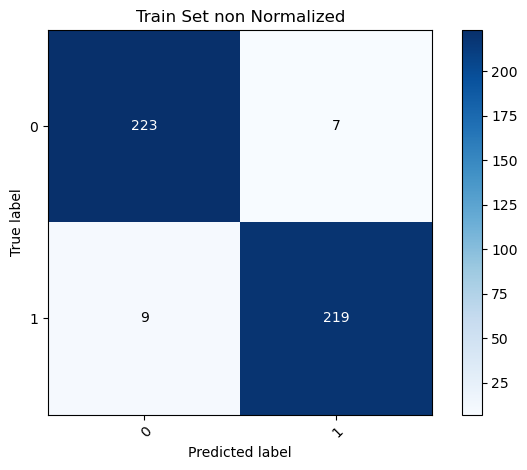

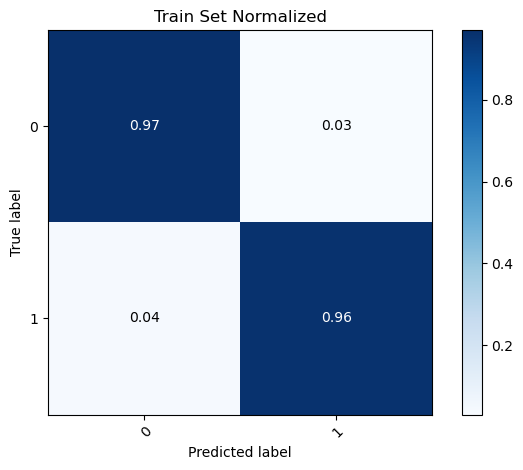

In [4]:
## NOTE This is the model on the training set
plot_confusion_matrix(true_labels, pred_labels, title = 'Train Set non Normalized')
plot_confusion_matrix(true_labels, pred_labels, normalize=True, title = 'Train Set Normalized')
print(classification_report(true_labels, pred_labels))

In [5]:
trainObjs_filtered['true_labels'] = true_labels
trainObjs_filtered['pred_labels'] = pred_labels
trainObjs_filtered['label_diffs'] = trainObjs_filtered['true_labels'].astype('int') - trainObjs_filtered['pred_labels'].astype('int')

# trainObjs_filtered['pred_labels'].value_counts()
# trainObjs_filtered['true_labels'].value_counts()
# trainObjs_filtered['labels'].value_counts()

In [6]:
trainObjs_filtered.head()

,Unnamed: 0,Unnamed: 1,ra,dec,labels,files,reds,true_labels,pred_labels,label_diffs
0,PCC_Bg,3848,49.8038,41.5811,0,sdss_ra=49.8038_dec=41.5811-label=0.png,2.1575,0,0,0
1,PCC_Bg,2340,49.6184,41.4546,0,sdss_ra=49.6184_dec=41.4546-label=0.png,1.7875,0,0,0
2,PCC_Bg,5416,50.0028,41.3384,0,sdss_ra=50.0028_dec=41.3384-label=0.png,3.4875,0,0,0
3,PCC_Bg,5239,49.9814,41.4202,0,sdss_ra=49.9814_dec=41.4202-label=0.png,1.5600,0,0,0
4,PCC_Bg,524,49.3342,41.3300,0,sdss_ra=49.3342_dec=41.33-label=0.png,8.2500,0,0,0


In [7]:
trainObjs_filtered['label_diffs'].value_counts()
trainObjs_filtered = trainObjs_filtered[['Unnamed: 0', 'Unnamed: 1', 'files', 'labels', 'true_labels', 'pred_labels', 'label_diffs', 'ra', 'dec']]
trainObjs_filtered.to_csv('../Sheets/trainObjsUpload.csv')
trainObjs_filtered

,Unnamed: 0,Unnamed: 1,files,labels,true_labels,pred_labels,label_diffs,ra,dec
0,PCC_Bg,3848,sdss_ra=49.8038_dec=41.5811-label=0.png,0,0,0,0,49.803800,41.581100
1,PCC_Bg,2340,sdss_ra=49.6184_dec=41.4546-label=0.png,0,0,0,0,49.618400,41.454600
2,PCC_Bg,5416,sdss_ra=50.0028_dec=41.3384-label=0.png,0,0,0,0,50.002800,41.338400
3,PCC_Bg,5239,sdss_ra=49.9814_dec=41.4202-label=0.png,0,0,0,0,49.981400,41.420200
4,PCC_Bg,524,sdss_ra=49.3342_dec=41.33-label=0.png,0,0,0,0,49.334200,41.330000
...,...,...,...,...,...,...,...,...,...
453,Spec_Mems,267,sdss_ra=50.622745654887_dec=41.0504450153301-l...,1,1,1,0,50.622746,41.050445
454,Spec_Mems,271,sdss_ra=50.6945934204297_dec=41.9412303787257-...,1,1,1,0,50.694593,41.941230
455,Spec_Mems,272,sdss_ra=49.7058490785794_dec=40.8275889370729-...,1,1,1,0,49.705849,40.827589
456,Spec_Mems,273,sdss_ra=49.112658441068_dec=41.1802159335769-l...,1,1,1,0,49.112658,41.180216


In [8]:
mem_mask = trainObjs_filtered['Unnamed: 0'] == 'PCC_Mems'
bg_mask = trainObjs_filtered['Unnamed: 0'] == 'PCC_Bg'
trainObjs_filtered[mem_mask][:10]

,Unnamed: 0,Unnamed: 1,files,labels,true_labels,pred_labels,label_diffs,ra,dec
116,PCC_Mems,39,sdss_ra=49.2516_dec=41.3224-label=1.png,1,1,1,0,49.2516,41.3224
117,PCC_Mems,218,sdss_ra=49.2835_dec=41.3141-label=1.png,1,1,1,0,49.2835,41.3141
118,PCC_Mems,245,sdss_ra=49.2874_dec=41.4252-label=1.png,1,1,1,0,49.2874,41.4252
119,PCC_Mems,313,sdss_ra=49.3008_dec=41.3811-label=1.png,1,1,0,1,49.3008,41.3811
120,PCC_Mems,348,sdss_ra=49.3048_dec=41.3333-label=1.png,1,1,1,0,49.3048,41.3333
121,PCC_Mems,357,sdss_ra=49.3063_dec=41.2975-label=1.png,1,1,1,0,49.3063,41.2975
122,PCC_Mems,359,sdss_ra=49.3067_dec=41.4355-label=1.png,1,1,1,0,49.3067,41.4355
123,PCC_Mems,461,sdss_ra=49.3237_dec=41.4215-label=1.png,1,1,1,0,49.3237,41.4215
124,PCC_Mems,468,sdss_ra=49.3256_dec=41.4929-label=1.png,1,1,1,0,49.3256,41.4929
125,PCC_Mems,601,sdss_ra=49.3476_dec=41.47-label=1.png,1,1,1,0,49.3476,41.4700


In [9]:
crossmatch = pd.read_csv(os.path.join('..', 'Sheets', 'trainObjects_filtered_CrossMatched.csv'), skiprows=1)
crossmatch.head()

,labels,true_labels,pred_labels,label_diffs,objID,ra,dec,r,r0,g_z0,u_g,g_z,g_r,g_i,r_i,r_z,distance
0,1,1,1,0,1237661059574333557,49.950960,41.547161,14.49405,14.11906,1.101402,0.217379,1.436186,0.775021,0.852034,0.077013,0.661165,2.052572
1,1,1,1,0,1237661059574333557,49.950960,41.547161,14.49405,14.11906,1.101402,0.217379,1.436186,0.775021,0.852034,0.077013,0.661165,2.052572
2,1,1,1,0,1237661059574333557,49.950960,41.547161,14.49405,14.11906,1.101402,0.217379,1.436186,0.775021,0.852034,0.077013,0.661165,2.052572
3,1,1,1,0,1237661059574333557,49.950960,41.547161,14.49405,14.11906,1.101402,0.217379,1.436186,0.775021,0.852034,0.077013,0.661165,2.052572
4,1,1,1,0,1237661059574334576,49.907725,41.472517,22.05002,21.68037,2.257058,-0.048845,2.587074,1.522949,2.158566,0.635616,1.064125,2.999543


In [10]:
## Uncomment for big pairplot:
pairDf_train = crossmatch[['ra', 'dec', 'r', 'u_g', 'g_z', 'g_r', 'true_labels', 'pred_labels', 'label_diffs']]

# p1 = sns.pairplot(pairDf, corner = False, hue = 'true_labels')
# p1.map_diag(sns.histplot)
# p1.map_upper(sns.kdeplot)
# p1.fig.suptitle('True labels')
# # p1.savefig(f'../Images/{modelName}-classifying-training-set.png')


In [11]:
# p2 = sns.pairplot(pairDf, corner = False, hue = 'pred_labels')
# p2.map_diag(sns.histplot)
# p2.map_upper(sns.kdeplot)
# p2.fig.suptitle('Predicted labels')
# # p1.savefig(f'../Images/{modelName}-classifying-training-set.png')


Text(0.5, 0.98, 'Differences between train set labels')

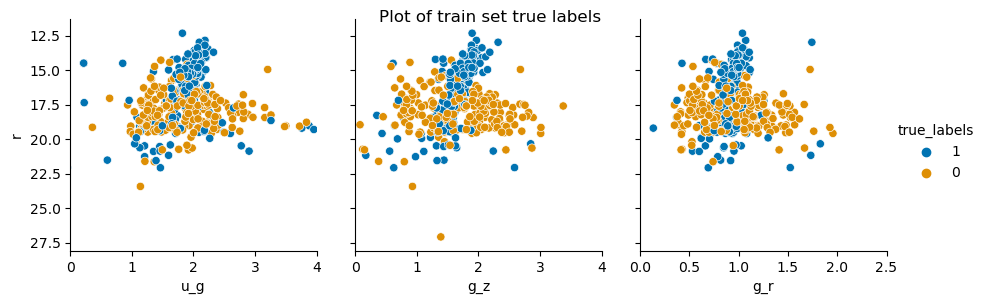

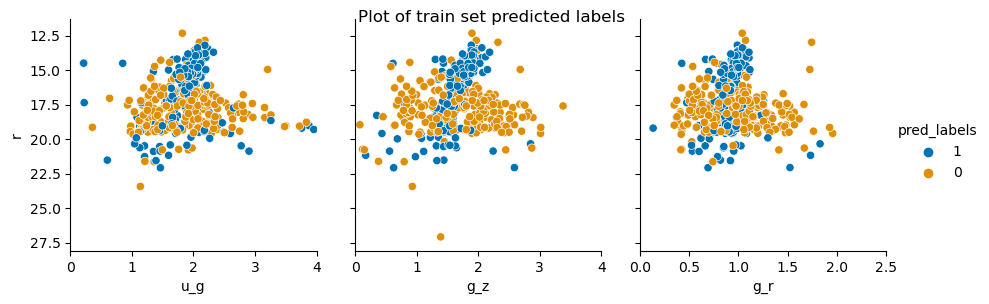

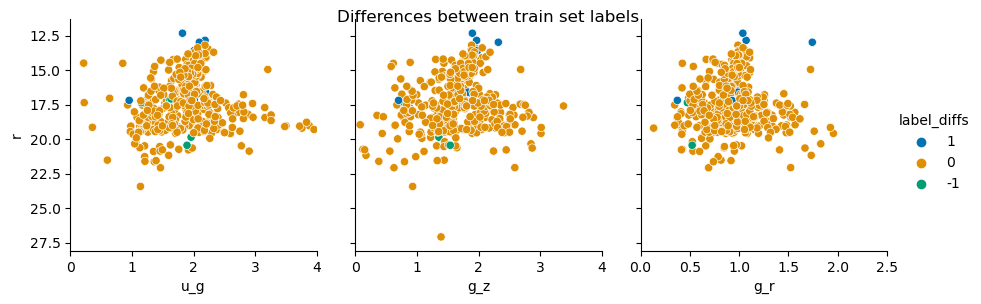

In [12]:
x_vars_train = pairDf_train[['u_g', 'g_z', 'g_r']]
y_vars_train = pairDf_train[['r']]

padding = 1
y_lim = (y_vars_train.min()[0] - padding , y_vars_train.max()[0] + padding)

true_plot_train = sns.PairGrid(pairDf_train, hue="true_labels", palette = 'colorblind', x_vars=x_vars_train, y_vars=y_vars_train, height = 3, hue_order = [1, 0])
# f.map_diag(sns.histplot, color=".3")
true_plot_train.map_offdiag(sns.scatterplot)
true_plot_train.add_legend()

## y limits
true_plot_train.axes[0, 0].set_ylim(y_lim[::-1])

# x limits
true_plot_train.axes[0, 0].set_xlim((0, 4))
true_plot_train.axes[0, 1].set_xlim((0, 4))
true_plot_train.axes[0, 2].set_xlim((0, 2.5))
true_plot_train.fig.suptitle('Plot of train set true labels')

pred_plot_train = sns.PairGrid(pairDf_train, hue="pred_labels", palette = 'colorblind', x_vars=x_vars_train, y_vars=y_vars_train, height = 3, hue_order = [1, 0])
# f.map_diag(sns.histplot, color=".3")
pred_plot_train.map_offdiag(sns.scatterplot)
pred_plot_train.add_legend()

## y limits
pred_plot_train.axes[0, 0].set_ylim(y_lim[::-1])

# x limits
pred_plot_train.axes[0, 0].set_xlim((0, 4))
pred_plot_train.axes[0, 1].set_xlim((0, 4))
pred_plot_train.axes[0, 2].set_xlim((0, 2.5))
pred_plot_train.fig.suptitle('Plot of train set predicted labels')

diff_plot_train = sns.PairGrid(pairDf_train, hue="label_diffs", palette = 'colorblind', x_vars=x_vars_train, y_vars=y_vars_train, height = 3, hue_order = [1, 0, -1])
# diff_plot_train = sns.PairGrid(pairDf_train, hue="label_diffs", palette = 'colorblind', x_vars=x_vars_train, y_vars=y_vars_train, height = 3)
# f.map_diag(sns.histplot, color=".3")
diff_plot_train.map_offdiag(sns.scatterplot)
diff_plot_train.add_legend()

## y limits
diff_plot_train.axes[0, 0].set_ylim(y_lim[::-1])

# x limits
diff_plot_train.axes[0, 0].set_xlim((0, 4))
diff_plot_train.axes[0, 1].set_xlim((0, 4))
diff_plot_train.axes[0, 2].set_xlim((0, 2.5))
diff_plot_train.fig.suptitle('Differences between train set labels')

In [13]:

cmap = 'copper'
cmap = 'coolwarm'
cmap = 'Accent'
# cmap = 'gnuplot'

# plt.figure()
# plt.scatter(pairDf_train['g_z'], pairDf_train['r'], c=pairDf_train['true_labels'], cmap = cmap)
# plt.xlim([0, 4])
# plt.gca().invert_yaxis()

# plt.figure()
# plt.scatter(pairDf_train['g_z'], pairDf_train['r'], c=pairDf_train['pred_labels'], cmap = cmap)
# plt.xlim([0, 4])
# plt.gca().invert_yaxis()

# plt.figure()
# plt.scatter(pairDf_train['g_z'], pairDf_train['r'], c=pairDf_train['label_diffs'], cmap = cmap)
# plt.xlim([0, 4])
# plt.gca().invert_yaxis()

Text(0, 0.5, '$r$')

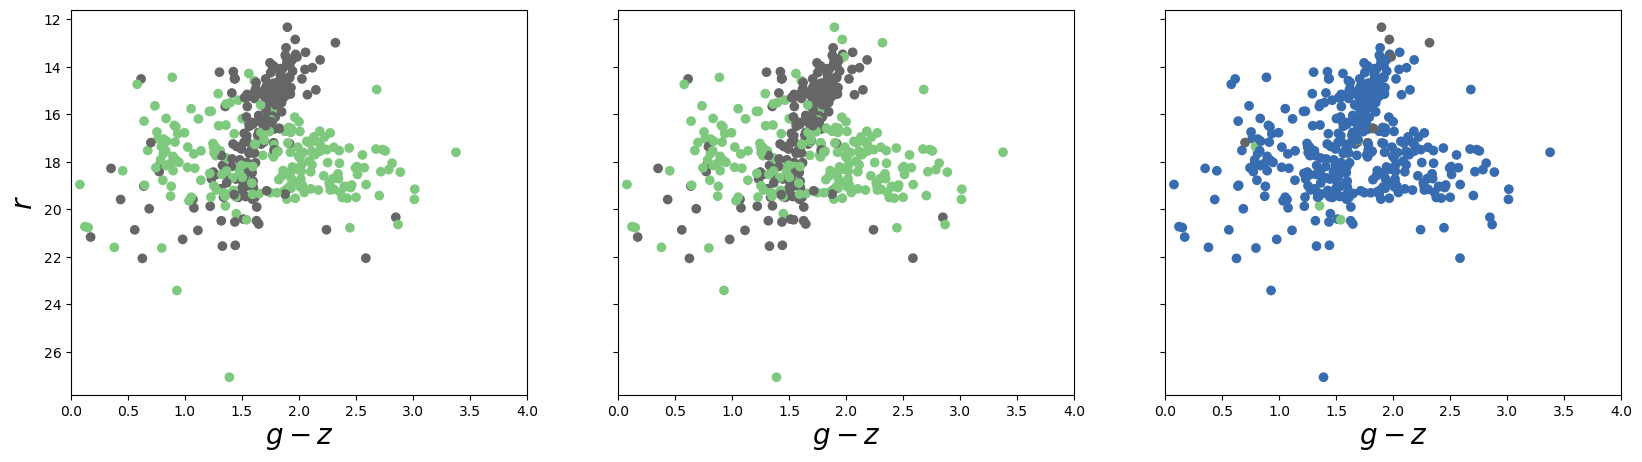

In [14]:
fig, axs = plt.subplots(1, 3, figsize = (20, 5), sharey=True)

axs[0].scatter(pairDf_train['g_z'], pairDf_train['r'], c=pairDf_train['true_labels'], cmap = cmap)
axs[0].set_xlim([0, 4])
axs[0].invert_yaxis()
axs[0].set_xlabel('$g-z$', fontsize = 20)

axs[1].scatter(pairDf_train['g_z'], pairDf_train['r'], c=pairDf_train['pred_labels'], cmap = cmap)
axs[1].set_xlim([0, 4])
axs[1].invert_yaxis()
axs[1].set_xlabel('$g-z$', fontsize = 20)

axs[2].scatter(pairDf_train['g_z'], pairDf_train['r'], c=pairDf_train['label_diffs'], cmap = cmap)
axs[2].set_xlim([0, 4])
axs[2].invert_yaxis()
axs[2].set_xlabel('$g-z$', fontsize = 20)

axs[0].set_ylabel('$r$', fontsize = 20)



In [15]:

### Helper funcs to return just the objects that match a certain label ###
member_mask = lambda df_in, col : df_in[df_in[col] == 1]
bg_mask = lambda df_in, col : df_in[df_in[col] == 0]
###

train_members_true = member_mask(pairDf_train, 'true_labels')
train_bgs_true = bg_mask(pairDf_train, 'true_labels')

train_members_pred = member_mask(pairDf_train, 'pred_labels')
train_bgs_pred = bg_mask(pairDf_train, 'pred_labels')

train_members_diffs = member_mask(pairDf_train, 'label_diffs')
train_bgs_diffs = bg_mask(pairDf_train, 'label_diffs')

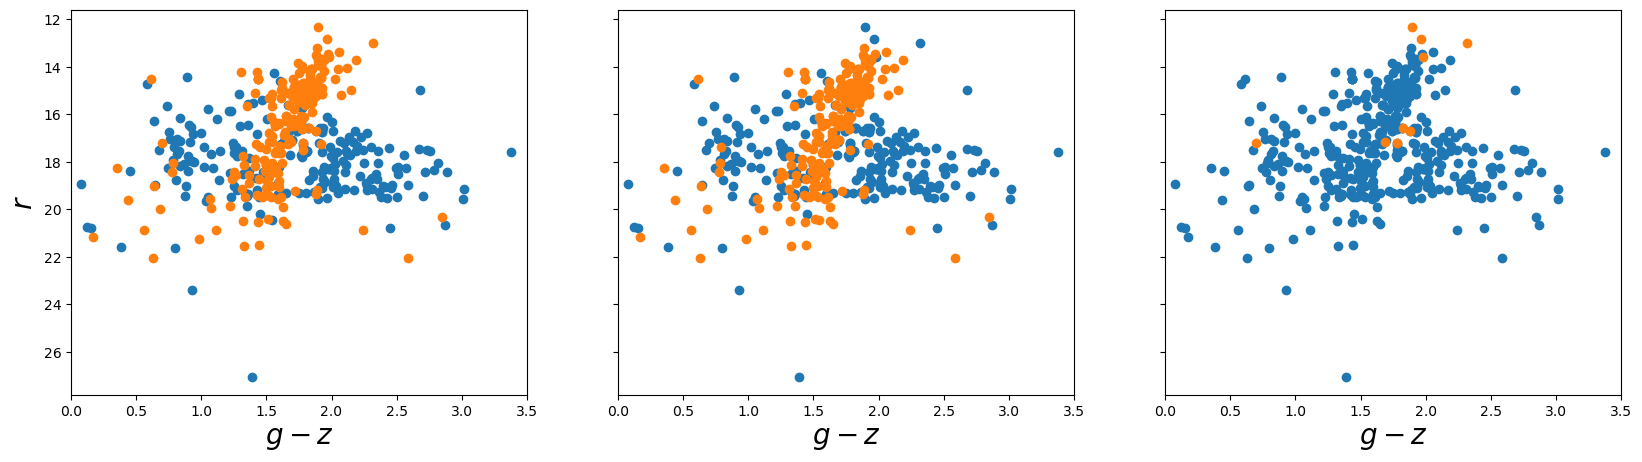

In [16]:
fig, axs = plt.subplots(1, 3, figsize = (20, 5), sharey=True)

axs[0].scatter(train_bgs_true['g_z'], train_bgs_true['r'], c='C0')
axs[0].scatter(train_members_true['g_z'], train_members_true['r'], c='C11')
axs[0].set_xlim([0, 3.5])
axs[0].invert_yaxis()
axs[0].set_xlabel('$g-z$', fontsize = 20)

axs[1].scatter(train_bgs_pred['g_z'], train_bgs_pred['r'], c='C0')
axs[1].scatter(train_members_pred['g_z'], train_members_pred['r'], c='C11')
axs[1].set_xlim([0, 3.5])
axs[1].invert_yaxis()
axs[1].set_xlabel('$g-z$', fontsize = 20)

axs[2].scatter(train_bgs_diffs['g_z'], train_bgs_diffs['r'], c='C0')
axs[2].scatter(train_members_diffs['g_z'], train_members_diffs['r'], c='C11')
axs[2].set_xlim([0, 3.5])
axs[2].invert_yaxis()
axs[2].set_xlabel('$g-z$', fontsize = 20)

axs[0].set_ylabel('$r$', fontsize = 20)
plt.savefig('../Images/WriteUpFigs/trainSet-classify.png')


In [17]:



# f.axes[0, 1].set_xlim(modMagr_lim[::-1])
# f.axes[0, 2].set_xlim(petroRad_r_lim)
# f.savefig(f'../Images/{modelName}-Rmag-vs-color.png')
# diff_plot.map(sns.scatterplot, s=1, alpha = 1)
# diff_plot

In [18]:
def dra_dec(ra,dec,ra0,dec0) :
	''' calculate angular separation in RA and Dec,
    	given input coords and reference coords,
    	all in radians
	'''
	dra = (np.sin(ra - ra0) * np.cos(dec))
	ddec = -np.cos(ra - ra0) * np.cos(dec) * np.sin(dec0) + np.sin(dec) * np.cos(dec0)
	return np.array([dra, ddec]) # in radians

ra0, dec0 = 49.9506671, 41.5116961 # NGC 1275, from NED

clustCent_R = []
for ra, dec in zip(pairDf_train['ra'], pairDf_train['dec']):
    dra, ddec = dra_dec(np.radians(ra), np.radians(dec), np.radians(ra0), np.radians(dec0))
    R_clust = np.sqrt(dra**2+ddec**2) * 75e3
    clustCent_R.append(R_clust)
pairDf_train['ClusterCentRad'] = clustCent_R

C:\Users\Jason\AppData\Local\Temp\ipykernel_15232\556787939.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairDf_train['ClusterCentRad'] = clustCent_R


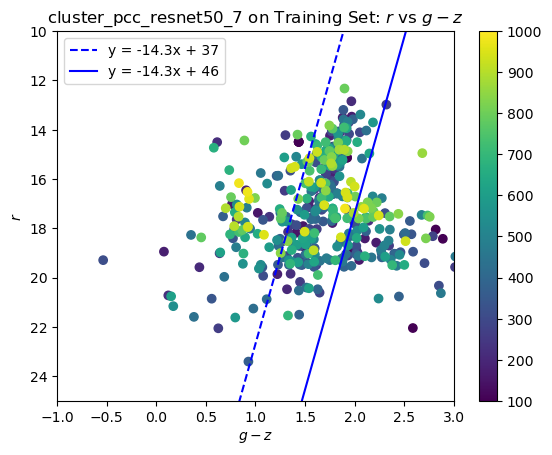

In [19]:
gz_slope = -14.3
gz_intercept1 = 37
gz_intercept2 = 46 # is this one intense enough?

x1 = pairDf_train['u_g']
x2 = pairDf_train['g_z']

x3 = pairDf_train['r']

plt.figure()
xx = np.linspace(-1, 3) 

plt.scatter(x2, x3, c = pairDf_train['ClusterCentRad'], vmin = 100, vmax = 1000)
plt.plot(xx, xx*gz_slope + gz_intercept1, 'b--', label = f'y = {str(gz_slope)}x + {str(gz_intercept1)}')
plt.plot(xx, xx*gz_slope + gz_intercept2, 'b-', label = f'y = {str(gz_slope)}x + {str(gz_intercept2)}')
plt.ylim([10, 25])
# # plt.xlim(gz_lim)
plt.xlim((-1, 3))
# plt.axvline(x=1.90, color = 'r')
# plt.axvline(x=1.85, color = 'r', label = 'x = 1.85')
# plt.axvline(x=1.30, color = 'r', label = 'x = 1.30')
# plt.axvline(x=1.575, color = 'r', label = 'x = 1.575')
plt.colorbar()
plt.gca().invert_yaxis()

plt.ylabel('$r$')
plt.xlabel('$g-z$')
plt.title(f'{modelName} on Training Set: $r$ vs $g-z$')
plt.legend()
plt.savefig('../Images/WriteUpFigs/Color-mag-trainset.png')
plt.show()

In [20]:
blueCloud = pairDf_train.loc[ (pairDf_train['r'] > -14.3*pairDf_train['g_z'] + 46)]
redSequence = pairDf_train.loc[ (pairDf_train['r'] > -14.3*pairDf_train['g_z'] + 37) & (pairDf_train['r'] < -14.3*pairDf_train['g_z'] + 46)]
redShoulder = pairDf_train.loc[ (pairDf_train['r'] < -14.3*pairDf_train['g_z'] + 37)]

aug_labels_BlueCloud = ['a' + str(x) for x in blueCloud['true_labels']]
aug_labels_RedSeq = ['b' + str(x) for x in redSequence['true_labels']]
aug_labels_RedShould = ['c' + str(x) for x in redShoulder['true_labels']]

# blueCloud['aug_labels'] = aug_labels_BlueCloud
# redSequence['aug_labels'] = aug_labels_RedSeq
# redShoulder['aug_labels'] = aug_labels_RedShould
pairDf_train.loc[blueCloud.index, 'aug_labels'] = aug_labels_BlueCloud
pairDf_train.loc[redSequence.index, 'aug_labels'] = aug_labels_RedSeq
pairDf_train.loc[redShoulder.index, 'aug_labels'] = aug_labels_RedShould

C:\Users\Jason\AppData\Local\Temp\ipykernel_15232\3618712003.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairDf_train.loc[blueCloud.index, 'aug_labels'] = aug_labels_BlueCloud


In [21]:
# pairDf['true_labels'].value_counts()
# blueCloud['labels'].value_counts()

In [22]:
colorRegions = pd.concat([blueCloud, redSequence, redShoulder], keys = ['BlueCloud', 'RedSequence', 'RedShoulder'])
# colorRegions
colorRegions['label_diffs'].value_counts()


 0    418
 1      9
-1      6
Name: label_diffs, dtype: int64

In [23]:
# colorRegions['label_diffs']['BlueCloud'].value_counts()
# colorRegions['label_diffs']['RedSequence'].value_counts() # reorder to 0, 1
# colorRegions['label_diffs']['RedShoulder'].value_counts()

In [24]:
# Cols = ['0', '-1', '1']
# Index = ['BlueCloud', 'RedSequence', 'RedShoulder']


# x = np.array([colorRegions['label_diffs']['BlueCloud'].value_counts(),
#               colorRegions['label_diffs']['RedSequence'].value_counts(), # reorder to 0, 1
#               colorRegions['label_diffs']['RedShoulder'].value_counts()]
#             )

# df = pd.DataFrame(x, index=Index, columns=Cols)

# sns.heatmap(df, annot=True, cmap='YlGnBu')
# df.style.background_gradient(cmap='Blues')
# ## This isn't quite correct - we want to see the false positives and negatives too

In [25]:
# colorRegions['labels']['BlueCloud'].value_counts()
# colorRegions['labels']['RedSequence'].value_counts()[::-1]
# colorRegions['labels']['RedShoulder'].value_counts()

In [26]:
def labeler(num):
    if (num > 0.01 and num < 0.033):
        return('1') # members
    else:
        return('0') # background
        

def get_images(df_in, dirName): 
        
    # df_in = df_in.drop_duplicates(subset = 'objID')
    # df_in['labels'] = pd.to_numeric(df_in['labels'], downcast='integer')
    
    img_width, img_height = 200, 200
    SkyServer_DataRelease = 'DR16'
    # dirName = 'PCC-and-SpecSearch'
    
    outDir = os.path.join('..', 'Images', dirName)
    
    fileList = list()

    ## create directory if doesn't currently exist 
    if not os.path.exists(outDir):
       os.makedirs(outDir)

    # if len(glob.glob(os.path.join(outDir, '*.png'))) == df_in.shape[0]:
    #     print('Skipping Populate')
    # else:
        # for id, r, d in zip(searchDf['objID'], df_in['ra'], df_in['dec']):
    
    for r, d, l in zip(df_in['ra'], df_in['dec'], df_in['labels']):
        img_array = SkyServer.getJpegImgCutout(ra = r, 
                                               dec = d, 
                                               width = img_width, 
                                               height = img_height, 
                                               scale = 0.1, 
                                               dataRelease = SkyServer_DataRelease)
        
        # print(f'{id}-label={labeler(z)}')
        # outPicTemplate = f'{id}-label={labeler(z)}.png'
        
        outPicTemplate = f'sdss_ra={r}_dec={d}-label={l}.png'
        
        img0 = PIL.Image.fromarray(img_array, 'RGB')
        img0.save(f'{outDir}/{outPicTemplate}')
        fileList.append(f'{outPicTemplate}')

    df_in['files'] = fileList

    # print(f'Finished populate with {len(fileList)} images')

In [27]:
searchDf = pd.read_csv('../Sheets/testSearch_SQL4_9_2024 7_16_13 AM.csv', skiprows = 1)

In [28]:
label_map = map(labeler, searchDf['z'])
searchDf['labels'] = list(label_map)
searchDf['labels'] = searchDf['labels'].astype(str)
searchDf['labels'].value_counts()


0    393
1    259
Name: labels, dtype: int64

In [29]:
searchDf.drop_duplicates(subset = 'objID')
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))
common_objs = intersection(searchDf['objID'], crossmatch['objID'])
cleanSearch = searchDf[~searchDf.objID.isin(common_objs)] 
cleanSearch.shape[0] == searchDf.shape[0] - len(common_objs)
searchDf.shape[0] - len(common_objs)

cleanSearch = cleanSearch.drop_duplicates(subset = 'objID')

In [30]:
## This populates

testDirectory = 'TestImgsCleaned_5-9-24'
get_images(cleanSearch, testDirectory)

C:\Users\Jason\anaconda3\envs\tf-gpu\lib\site-packages\sciserver-2.1.0-py3.9.egg\SciServer\SkyServer.py:124: Warning: In Authentication.getToken: Authentication token is not defined: the user did not log in with the Authentication.login function, or the token has not been stored in the command line argument --ident.


In [31]:
cleanSearch = cleanSearch.drop_duplicates(subset = 'objID')
cleanSearch.head()

,objID,ra,dec,R_mag,r0,g_z0,u_g,g_z,g_r,g_i,r_i,r_z,petroRad_r,specObjID,z,zErr,zWarning,distance,labels,files
11,1237661122388033567,49.843334,41.429343,14.28693,13.91953,1.594043,2.131654,1.922055,1.021379,1.532359,0.510980,0.900676,6.129025,1875799322759555072,0.018113,0.000006,0,6.844706,1,sdss_ra=49.8433339393247_dec=41.4293429843872-...
13,1237661122388033863,49.936755,41.398687,17.12540,16.75802,1.713811,2.371679,2.041801,1.170483,1.675606,0.505123,0.871319,18.016050,1874671498455705600,0.135237,0.000024,0,6.879356,0,sdss_ra=49.9367551285574_dec=41.3986865815753-...
22,1237661122388034402,49.906699,41.380047,15.79804,15.43007,1.396773,2.037449,1.725286,0.891335,1.363700,0.472364,0.833951,12.311910,1875796299102578688,0.018363,0.000015,0,8.183352,1,sdss_ra=49.9066992302963_dec=41.3800473541336-...
90,1237670960021505209,50.036431,41.774622,17.46084,17.06035,1.088861,1.745869,1.446409,0.860964,1.233713,0.372749,0.585445,1.572295,1875901852218845184,-0.000041,0.000008,0,16.198894,0,sdss_ra=50.036430938291_dec=41.7746219007254-l...
183,1237661055818465980,49.723335,41.987172,16.34774,15.97935,0.392425,1.156849,0.721315,0.473238,0.724489,0.251251,0.248077,19.570090,1874757535240579072,-0.000225,0.000009,0,30.150433,0,sdss_ra=49.7233351705975_dec=41.9871720395959-...


In [32]:
# testImgs = os.path.join('..', 'Images', 'TestImgsCleaned_4-17-24', '*.png')
cleanSearch = cleanSearch.drop_duplicates(subset = 'objID')
cleanSearch.head()

testImgList = cleanSearch['files']

misses = 0
true_labels = [None]*len(testImgList)
pred_labels = [None]*len(testImgList)

for ind, imString in enumerate(testImgList):
    imString = os.path.join('..', 'Images', testDirectory, imString)
    
    ground_truth_label = imString[-5]
    pred_label = make_prediction(imString)

    true_labels[ind] = ground_truth_label
    pred_labels[ind] = pred_label
    
    if pred_label != ground_truth_label:
        misses += 1

print(f'{misses} misses on predicting test set')
print(f'{len(testImgList)} images in test set')

cleanSearch['true_labels'] = true_labels
cleanSearch['pred_labels'] = pred_labels
cleanSearch['label_diffs'] = cleanSearch['true_labels'].astype('int') - cleanSearch['pred_labels'].astype('int')

# y_true = [x[-5] for x in glob.glob(testImgs)] 
# y_pred = [None]*len(y_true)
# # len(y_pred) == len(y_true)

# counter = 0
# for ind, x in enumerate(glob.glob(testImgs)):
#     pred = make_prediction(x)
#     y_pred[ind] = pred
#     if pred != x[-5]:
#         counter += 1
        
# print(f'{counter} misses on test set')
# print(f'{len(glob.glob(testImgs))} images in test set')

28 misses on predicting test set
335 images in test set


In [33]:
cleanSearch.head()

,objID,ra,dec,R_mag,r0,g_z0,u_g,g_z,g_r,g_i,...,specObjID,z,zErr,zWarning,distance,labels,files,true_labels,pred_labels,label_diffs
11,1237661122388033567,49.843334,41.429343,14.28693,13.91953,1.594043,2.131654,1.922055,1.021379,1.532359,...,1875799322759555072,0.018113,0.000006,0,6.844706,1,sdss_ra=49.8433339393247_dec=41.4293429843872-...,1,1,0
13,1237661122388033863,49.936755,41.398687,17.12540,16.75802,1.713811,2.371679,2.041801,1.170483,1.675606,...,1874671498455705600,0.135237,0.000024,0,6.879356,0,sdss_ra=49.9367551285574_dec=41.3986865815753-...,0,0,0
22,1237661122388034402,49.906699,41.380047,15.79804,15.43007,1.396773,2.037449,1.725286,0.891335,1.363700,...,1875796299102578688,0.018363,0.000015,0,8.183352,1,sdss_ra=49.9066992302963_dec=41.3800473541336-...,1,0,1
90,1237670960021505209,50.036431,41.774622,17.46084,17.06035,1.088861,1.745869,1.446409,0.860964,1.233713,...,1875901852218845184,-0.000041,0.000008,0,16.198894,0,sdss_ra=50.036430938291_dec=41.7746219007254-l...,0,0,0
183,1237661055818465980,49.723335,41.987172,16.34774,15.97935,0.392425,1.156849,0.721315,0.473238,0.724489,...,1874757535240579072,-0.000225,0.000009,0,30.150433,0,sdss_ra=49.7233351705975_dec=41.9871720395959-...,0,0,0


In [34]:
cleanSearch.to_csv('../Sheets/IndependentTestSet_Cleaned.csv')
# cleanSearch['pred_labels'] = y_pred
# # cleanSearch['label_diffs'] = y_true - y_pred
# cleanSearch['label_diffs'] = cleanSearch['labels'].astype('int') - cleanSearch['pred_labels'].astype('int')



Text(0.5, 0.98, 'Differences between Test Set labels')

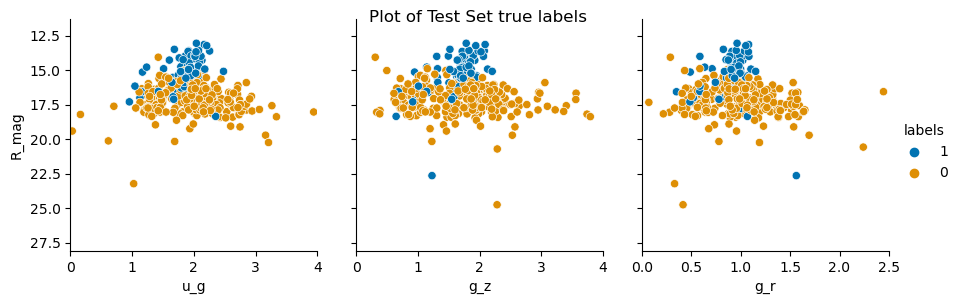

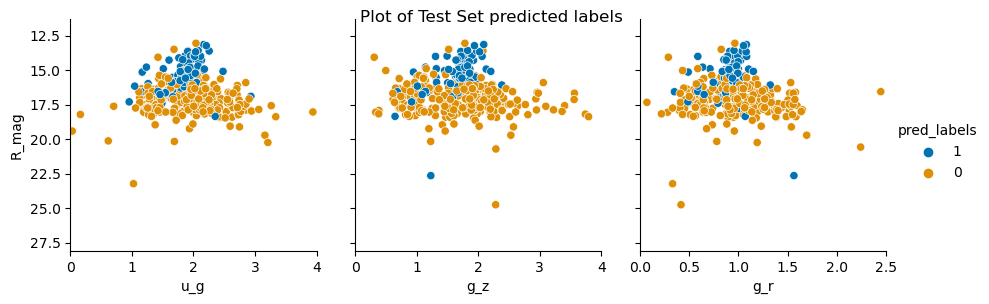

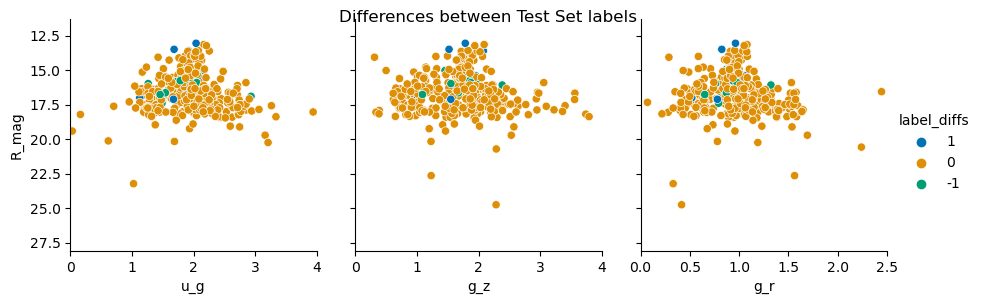

In [35]:

testPairDf = cleanSearch[['ra', 'dec', 'R_mag', 'u_g', 'g_z', 'g_r', 'labels', 'pred_labels', 'label_diffs']]

x_vars_test = testPairDf[['u_g', 'g_z', 'g_r']]
y_vars_test = testPairDf[['R_mag']]

true_plot_test = sns.PairGrid(testPairDf, hue="labels", palette = 'colorblind', x_vars=x_vars_test, y_vars=y_vars_test, height = 3)
# f.map_diag(sns.histplot, color=".3")
true_plot_test.map_offdiag(sns.scatterplot)
true_plot_test.add_legend()

## y limits
true_plot_test.axes[0, 0].set_ylim(y_lim[::-1])

# x limits
true_plot_test.axes[0, 0].set_xlim((0, 4))
true_plot_test.axes[0, 1].set_xlim((0, 4))
true_plot_test.axes[0, 2].set_xlim((0, 2.5))
true_plot_test.fig.suptitle('Plot of Test Set true labels')

pred_plot_test = sns.PairGrid(testPairDf, hue="pred_labels", palette = 'colorblind', x_vars=x_vars_test, y_vars=y_vars_test, height = 3)
# f.map_diag(sns.histplot, color=".3")
pred_plot_test.map_offdiag(sns.scatterplot)
pred_plot_test.add_legend()

## y limits
pred_plot_test.axes[0, 0].set_ylim(y_lim[::-1])

# x limits
pred_plot_test.axes[0, 0].set_xlim((0, 4))
pred_plot_test.axes[0, 1].set_xlim((0, 4))
pred_plot_test.axes[0, 2].set_xlim((0, 2.5))
pred_plot_test.fig.suptitle('Plot of Test Set predicted labels')

diff_plot_test = sns.PairGrid(testPairDf, hue="label_diffs", palette = 'colorblind', x_vars=x_vars_test, y_vars=y_vars_test, height = 3, hue_order = [1, 0, -1] )
# diff_plot_test = sns.PairGrid(testPairDf, hue="label_diffs", x_vars=x_vars_test, y_vars=y_vars_test, height = 3, hue_order = [1, 0, -1] )
# diff_plot_test = sns.PairGrid(testPairDf, hue="label_diffs", palette = 'colorblind', x_vars=x_vars_test, y_vars=y_vars_test, height = 3)
# f.map_diag(sns.histplot, color=".3")
diff_plot_test.map_offdiag(sns.scatterplot)
diff_plot_test.add_legend()

## y limits
diff_plot_test.axes[0, 0].set_ylim(y_lim[::-1])

# x limits
diff_plot_test.axes[0, 0].set_xlim((0, 4))
diff_plot_test.axes[0, 1].set_xlim((0, 4))
diff_plot_test.axes[0, 2].set_xlim((0, 2.5))
diff_plot_test.fig.suptitle('Differences between Test Set labels')

In [36]:
# plt.figure()
# xx = np.linspace(1, 2.5) 
# x2 = testPairDf['g_z']
# x3 = testPairDf['R_mag']


# plt.scatter(x2, x3)

# plt.ylabel('$R_{mag}$')
# plt.gca().invert_yaxis()
# plt.xlabel('g_z')
# plt.title('PCC Brights : $R_{mag}$ vs g-z')
# plt.legend()
# plt.show()

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       247
           1       0.84      0.84      0.84        88

    accuracy                           0.92       335
   macro avg       0.89      0.89      0.89       335
weighted avg       0.92      0.92      0.92       335



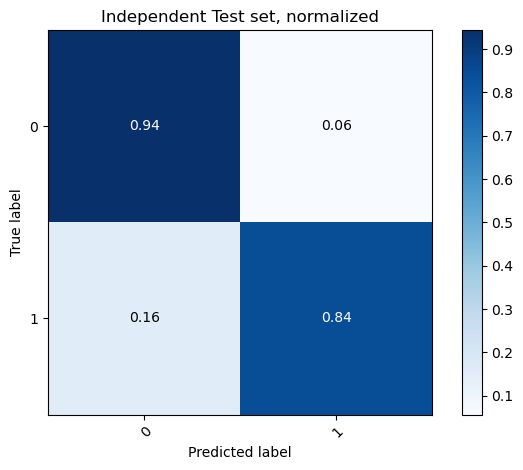

In [37]:
print(classification_report(true_labels, pred_labels))
plot_confusion_matrix(true_labels, pred_labels, normalize=True, title = 'Independent Test set, normalized')
plt.savefig('../Images/WriteUpFigs/Independent-Test-set-normalized.png')

In [38]:
# cleanSearch['labels'].value_counts()

Blue Cloud
-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        82
           1       0.83      0.83      0.83         6

    accuracy                           0.98        88
   macro avg       0.91      0.91      0.91        88
weighted avg       0.98      0.98      0.98        88

-----------------------------------------------------------------

Red Sequence
-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.94      0.92        66
           1       0.98      0.96      0.97       181

    accuracy                           0.96       247
   macro avg       0.94      0.95      0.94       247
weighted avg       0.96      0.96      0.96       247

-----------------------------------------------------------------

Red Shoulder
-------------------------------------------

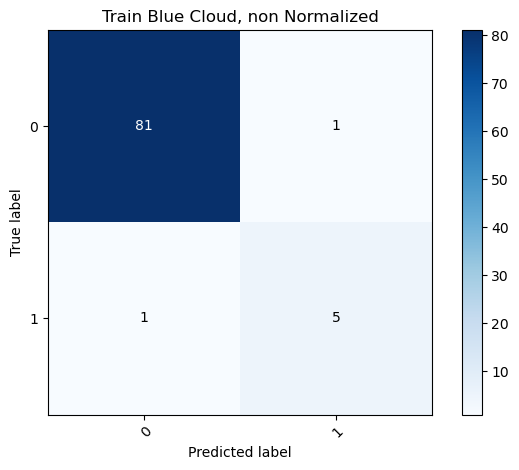

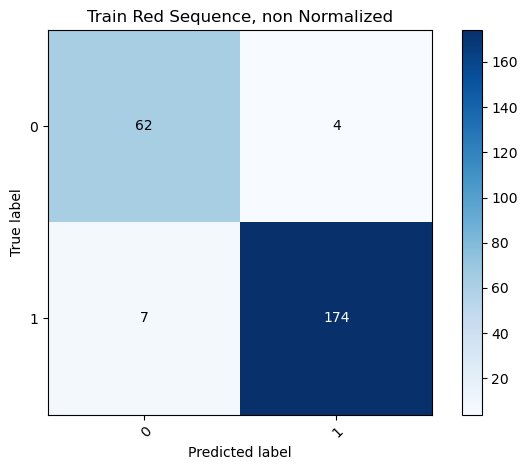

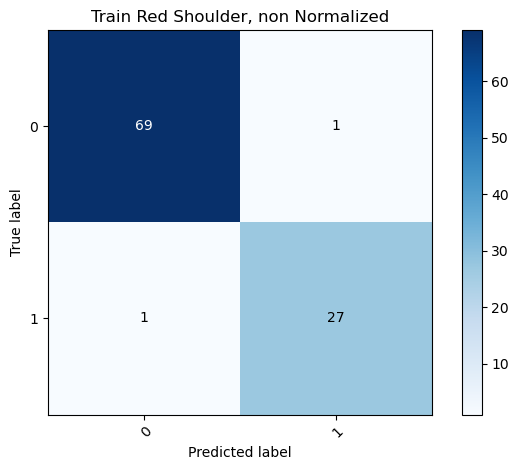

In [39]:
print('Blue Cloud')
print('-----------------------------------------------------------------')
plot_confusion_matrix(blueCloud['true_labels'], blueCloud['pred_labels'], title = 'Train Blue Cloud, non Normalized')
print(classification_report(blueCloud['true_labels'], blueCloud['pred_labels']))
print('-----------------------------------------------------------------')

print('\nRed Sequence')
print('-----------------------------------------------------------------')
plot_confusion_matrix(redSequence['true_labels'], redSequence['pred_labels'], title = 'Train Red Sequence, non Normalized')
print(classification_report(redSequence['true_labels'], redSequence['pred_labels']))
print('-----------------------------------------------------------------')

print('\nRed Shoulder')
print('-----------------------------------------------------------------')
plot_confusion_matrix(redShoulder['true_labels'], redShoulder['pred_labels'], title = 'Train Red Shoulder, non Normalized')
print(classification_report(redShoulder['true_labels'], redShoulder['pred_labels']))
print('-----------------------------------------------------------------')


Blue Cloud
-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        82
           1       0.83      0.83      0.83         6

    accuracy                           0.98        88
   macro avg       0.91      0.91      0.91        88
weighted avg       0.98      0.98      0.98        88

-----------------------------------------------------------------
Red Sequence
-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.94      0.92        66
           1       0.98      0.96      0.97       181

    accuracy                           0.96       247
   macro avg       0.94      0.95      0.94       247
weighted avg       0.96      0.96      0.96       247

-----------------------------------------------------------------
Red Shoulder
---------------------------------------------

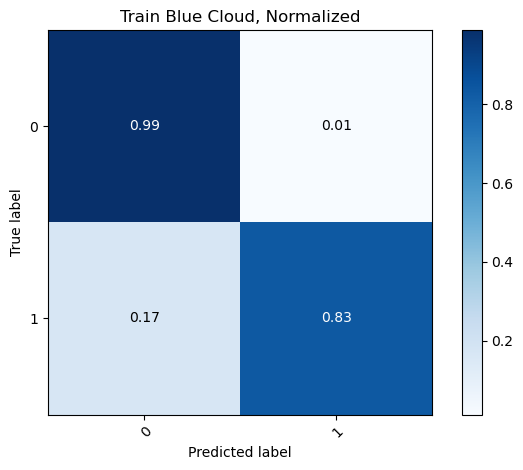

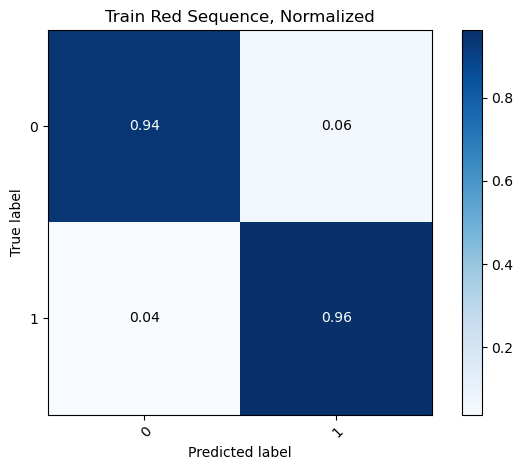

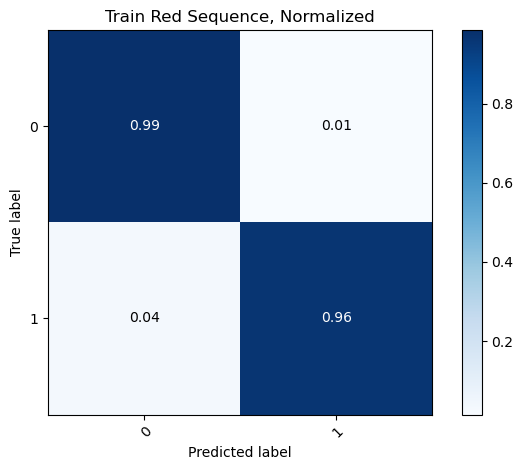

In [40]:
print('Blue Cloud')
print('-----------------------------------------------------------------')
plot_confusion_matrix(blueCloud['true_labels'], blueCloud['pred_labels'], normalize = True, title = 'Train Blue Cloud, Normalized')
plt.savefig('../Images/WriteUpFigs/Train-BlueCloud-normalized.png')
print(classification_report(blueCloud['true_labels'], blueCloud['pred_labels']))
print('-----------------------------------------------------------------')

print('Red Sequence')
print('-----------------------------------------------------------------')
plot_confusion_matrix(redSequence['true_labels'], redSequence['pred_labels'], normalize = True, title = 'Train Red Sequence, Normalized')
plt.savefig('../Images/WriteUpFigs/Train-RedSequence-normalized.png')
print(classification_report(redSequence['true_labels'], redSequence['pred_labels']))
print('-----------------------------------------------------------------')

print('Red Shoulder')
print('-----------------------------------------------------------------')
plot_confusion_matrix(redShoulder['true_labels'], redShoulder['pred_labels'], normalize = True, title = 'Train Red Sequence, Normalized')
plt.savefig('../Images/WriteUpFigs/Train-RedShoulder-normalized.png')
print(classification_report(redShoulder['true_labels'], redShoulder['pred_labels']))
print('-----------------------------------------------------------------')


In [41]:
cleanSearch

,objID,ra,dec,R_mag,r0,g_z0,u_g,g_z,g_r,g_i,...,specObjID,z,zErr,zWarning,distance,labels,files,true_labels,pred_labels,label_diffs
11,1237661122388033567,49.843334,41.429343,14.28693,13.91953,1.594043,2.131654,1.922055,1.021379,1.532359,...,1875799322759555072,0.018113,0.000006,0,6.844706,1,sdss_ra=49.8433339393247_dec=41.4293429843872-...,1,1,0
13,1237661122388033863,49.936755,41.398687,17.12540,16.75802,1.713811,2.371679,2.041801,1.170483,1.675606,...,1874671498455705600,0.135237,0.000024,0,6.879356,0,sdss_ra=49.9367551285574_dec=41.3986865815753-...,0,0,0
22,1237661122388034402,49.906699,41.380047,15.79804,15.43007,1.396773,2.037449,1.725286,0.891335,1.363700,...,1875796299102578688,0.018363,0.000015,0,8.183352,1,sdss_ra=49.9066992302963_dec=41.3800473541336-...,1,0,1
90,1237670960021505209,50.036431,41.774622,17.46084,17.06035,1.088861,1.745869,1.446409,0.860964,1.233713,...,1875901852218845184,-0.000041,0.000008,0,16.198894,0,sdss_ra=50.036430938291_dec=41.7746219007254-l...,0,0,0
183,1237661055818465980,49.723335,41.987172,16.34774,15.97935,0.392425,1.156849,0.721315,0.473238,0.724489,...,1874757535240579072,-0.000225,0.000009,0,30.150433,0,sdss_ra=49.7233351705975_dec=41.9871720395959-...,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,1237661061184619260,50.041287,42.962649,14.95002,14.52303,1.138123,1.914467,1.519324,0.902732,1.327225,...,1874746540124301312,0.018849,0.000013,0,87.074371,1,sdss_ra=50.0412874848972_dec=42.9626492472529-...,1,1,0
648,1237661061184685028,50.183969,42.967872,16.34030,15.92945,1.543229,2.023552,1.910030,1.027729,1.522601,...,1875905975387449344,0.049766,0.000010,0,87.920198,0,sdss_ra=50.1839691396618_dec=42.9678720520402-...,0,0,0
649,1237661121314685733,50.188202,40.058414,17.14789,16.74432,1.730251,2.253605,2.090557,1.133398,1.657532,...,1875808668608391168,0.085545,0.000020,0,87.967883,0,sdss_ra=50.1882022761316_dec=40.0584141119316-...,0,0,0
650,1237661056891948400,49.694543,42.987755,23.21459,22.78532,3.891844,1.026676,4.275085,0.330887,1.144054,...,1874736919397558272,2.170753,0.000471,5,89.185113,0,sdss_ra=49.6945425307804_dec=42.9877553873081-...,0,0,0


In [42]:
blueCloud_test = cleanSearch.loc[ (cleanSearch['R_mag'] > -14.3*cleanSearch['g_z'] + 46)]
redSequence_test = cleanSearch.loc[ (cleanSearch['R_mag'] > -14.3*cleanSearch['g_z'] + 37) & (cleanSearch['R_mag'] < -14.3*cleanSearch['g_z'] + 46)]
redShoulder_test = cleanSearch.loc[ (cleanSearch['R_mag'] < -14.3*cleanSearch['g_z'] + 37)]

aug_labels_BlueCloud_test = ['a' + str(x) for x in blueCloud_test['true_labels']]
aug_labels_RedSeq_test = ['b' + str(x) for x in redSequence_test['true_labels']]
aug_labels_RedShould_test = ['c' + str(x) for x in redShoulder_test['true_labels']]

# blueCloud['aug_labels'] = aug_labels_BlueCloud
# redSequence['aug_labels'] = aug_labels_RedSeq
# redShoulder['aug_labels'] = aug_labels_RedShould
cleanSearch.loc[blueCloud_test.index, 'aug_labels'] = aug_labels_BlueCloud_test
cleanSearch.loc[redSequence_test.index, 'aug_labels'] = aug_labels_RedSeq_test
cleanSearch.loc[redShoulder_test.index, 'aug_labels'] = aug_labels_RedShould_test

Blue Cloud - Indep. Test Set
-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        89
           1       0.50      1.00      0.67         1

    accuracy                           0.99        90
   macro avg       0.75      0.99      0.83        90
weighted avg       0.99      0.99      0.99        90

-----------------------------------------------------------------
Red Sequence - Indep. Test Set
-----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.88      0.87        78
           1       0.87      0.83      0.85        71

    accuracy                           0.86       149
   macro avg       0.86      0.86      0.86       149
weighted avg       0.86      0.86      0.86       149

-----------------------------------------------------------------
Red Shoulder - Indep. 

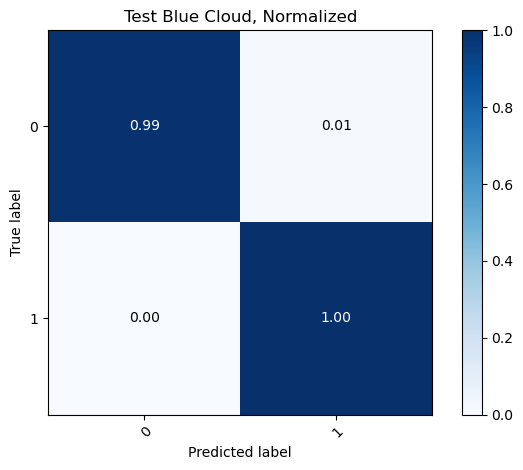

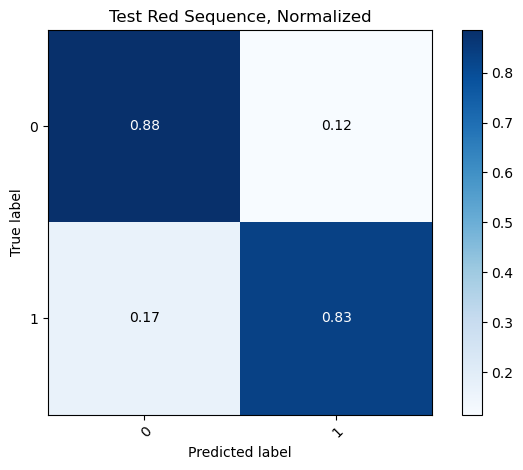

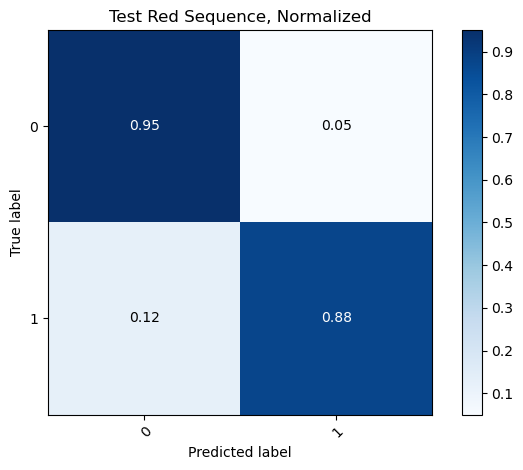

In [43]:
print('Blue Cloud - Indep. Test Set')
print('-----------------------------------------------------------------')
plot_confusion_matrix(blueCloud_test['true_labels'], blueCloud_test['pred_labels'], normalize = True, title = 'Test Blue Cloud, Normalized')
plt.savefig('../Images/WriteUpFigs/Test-BlueCloud-normalized.png')
print(classification_report(blueCloud_test['true_labels'], blueCloud_test['pred_labels']))
print('-----------------------------------------------------------------')

print('Red Sequence - Indep. Test Set')
print('-----------------------------------------------------------------')
plot_confusion_matrix(redSequence_test['true_labels'], redSequence_test['pred_labels'], normalize = True, title = 'Test Red Sequence, Normalized')
plt.savefig('../Images/WriteUpFigs/Test-RedSequence-normalized.png')
print(classification_report(redSequence_test['true_labels'], redSequence_test['pred_labels']))
print('-----------------------------------------------------------------')

print('Red Shoulder - Indep. Test Set')
print('-----------------------------------------------------------------')
plot_confusion_matrix(redShoulder_test['true_labels'], redShoulder_test['pred_labels'], normalize = True, title = 'Test Red Sequence, Normalized')
plt.savefig('../Images/WriteUpFigs/Test-RedShoulder-normalized.png')
print(classification_report(redShoulder_test['true_labels'], redShoulder_test['pred_labels']))
print('-----------------------------------------------------------------')


In [50]:
blueMemMask = blueCloud['true_labels'] == 1
bluebgMask = blueCloud['true_labels'] == 0
blueCloud[blueMemMask]
blueCloud[bluebgMask]


,ra,dec,r,u_g,g_z,g_r,true_labels,pred_labels,label_diffs,ClusterCentRad
7,49.983366,41.455261,18.84386,1.555840,1.950048,1.016344,0,0,0,80.532793
9,50.029920,41.552969,18.42844,3.159212,2.888931,1.524950,0,0,0,94.603199
10,49.988331,41.445875,18.05160,2.727100,2.817200,1.565123,0,0,0,93.743552
12,49.981414,41.420159,18.69531,2.256126,2.309149,1.302322,0,0,0,123.559025
19,49.787476,41.529229,19.28735,2.378429,2.046179,1.155357,0,0,0,161.576472
...,...,...,...,...,...,...,...,...,...,...
399,50.770069,41.754280,14.95202,3.206179,2.682261,1.724278,0,0,0,862.249209
417,50.676965,41.975854,18.52508,2.634863,2.513210,1.616327,0,0,0,933.965107
421,49.125185,41.884853,17.48358,2.349323,2.243109,1.251408,0,0,0,943.116217
422,49.235909,41.996330,27.06348,-3.799187,1.389593,-2.617714,0,0,0,943.165092


In [45]:
redMemMask = redSequence['true_labels'] == 1
redBGMask = redSequence['true_labels'] == 0
redSequence[redBGMask]

,ra,dec,r,u_g,g_z,g_r,true_labels,pred_labels,label_diffs,ClusterCentRad
24,49.862528,41.623422,17.78735,2.390419,1.776218,0.883852,0,0,0,169.822584
33,49.771221,41.470204,15.73157,1.647493,1.776888,0.839318,0,0,0,184.141353
46,49.849853,41.661913,19.84847,1.961037,1.354614,0.704018,0,1,-1,220.015905
74,49.956393,41.313826,20.17738,1.063026,1.449718,0.525467,0,0,0,259.071469
75,49.734563,41.634621,17.83581,1.472054,1.365313,0.753426,0,0,0,265.850112
...,...,...,...,...,...,...,...,...,...,...
423,49.333909,42.067375,18.13881,1.918421,1.496563,0.880371,0,0,0,944.122344
424,50.218789,40.821838,16.55110,2.048006,1.908499,1.053564,0,0,0,940.854461
425,50.872697,41.725122,17.06355,2.169674,1.692694,1.007315,0,0,0,944.516571
426,50.441006,40.891914,16.74638,2.015545,1.927032,1.068163,0,0,0,944.117230


In [46]:
blueCloud_test

,objID,ra,dec,R_mag,r0,g_z0,u_g,g_z,g_r,g_i,...,specObjID,z,zErr,zWarning,distance,labels,files,true_labels,pred_labels,label_diffs
13,1237661122388033863,49.936755,41.398687,17.12540,16.75802,1.713811,2.371679,2.041801,1.170483,1.675606,...,1874671498455705600,0.135237,0.000024,0,6.879356,0,sdss_ra=49.9367551285574_dec=41.3986865815753-...,0,0,0
300,1237661059574007036,49.106176,41.936792,17.15317,16.78016,1.873536,2.328091,2.206551,1.235912,1.757078,...,1875858696387454976,0.113469,0.000023,0,45.419668,0,sdss_ra=49.1061764946493_dec=41.9367922608528-...,0,0,0
302,1237661060111466837,50.951906,41.620439,17.06462,16.61131,1.918562,2.447615,2.323275,1.321404,1.882639,...,1875912847335122944,0.134142,0.000023,0,45.581673,0,sdss_ra=50.9519056437048_dec=41.6204392969173-...,0,0,0
305,1237670458048054247,49.143680,41.049219,17.57169,17.20682,3.077607,3.264580,3.403361,1.594614,2.759380,...,1874700085758027776,0.000074,0.000010,0,45.668366,0,sdss_ra=49.1436803129268_dec=41.0492190627576-...,0,0,0
307,1237661056355665148,50.831448,41.891500,17.87430,17.38974,2.790933,2.868820,3.223539,1.649103,2.634937,...,1874785297909180416,0.000196,0.000008,0,45.675761,0,sdss_ra=50.8314480952228_dec=41.8914999051289-...,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,1237661056892011768,49.738184,42.923876,17.08256,16.66108,1.883533,2.905617,2.259827,1.265995,1.804947,...,1875894980271171584,0.130435,0.000019,0,85.152037,0,sdss_ra=49.7381835090633_dec=42.9238755183778-...,0,0,0
638,1237661056892011174,49.813814,42.938644,16.51002,16.08684,1.787268,2.118050,2.165077,1.241135,1.718071,...,1874738018909186048,0.131149,0.000020,0,85.736144,0,sdss_ra=49.8138142380191_dec=42.9386441468547-...,0,0,0
645,1237661082125796443,49.862256,40.066494,17.12500,16.64526,3.129071,2.551435,3.557374,1.572657,2.838091,...,1874657479682451456,0.000035,0.000009,0,86.881043,0,sdss_ra=49.8622559727579_dec=40.0664944813347-...,0,0,0
649,1237661121314685733,50.188202,40.058414,17.14789,16.74432,1.730251,2.253605,2.090557,1.133398,1.657532,...,1875808668608391168,0.085545,0.000020,0,87.967883,0,sdss_ra=50.1882022761316_dec=40.0584141119316-...,0,0,0


In [47]:
true_labels = testPairDf['labels'].to_list()
true_labels = [int(x) for x in true_labels]
testPairDf['true_labels'] = true_labels

pred_labels = testPairDf['pred_labels'].to_list()
pred_labels = [int(x) for x in pred_labels]
testPairDf['pred_labels'] = pred_labels

C:\Users\Jason\AppData\Local\Temp\ipykernel_15232\3013721896.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testPairDf['true_labels'] = true_labels
C:\Users\Jason\AppData\Local\Temp\ipykernel_15232\3013721896.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testPairDf['pred_labels'] = pred_labels


In [48]:

### Helper funcs to return just the objects that match a certain label ###
member_mask = lambda df_in, col : df_in[df_in[col] == 1]
bg_mask = lambda df_in, col : df_in[df_in[col] == 0]
neg_mask = lambda df_in, col : df_in[df_in[col] == -1]
###

test_members_true = member_mask(testPairDf, 'true_labels')
test_bgs_true = bg_mask(testPairDf, 'true_labels')

test_members_pred = member_mask(testPairDf, 'pred_labels')
test_bgs_pred = bg_mask(testPairDf, 'pred_labels')

test_pos_diffs = member_mask(testPairDf, 'label_diffs')
test_zero_diffs = bg_mask(testPairDf, 'label_diffs')
test_neg_diffs = neg_mask(testPairDf, 'label_diffs')


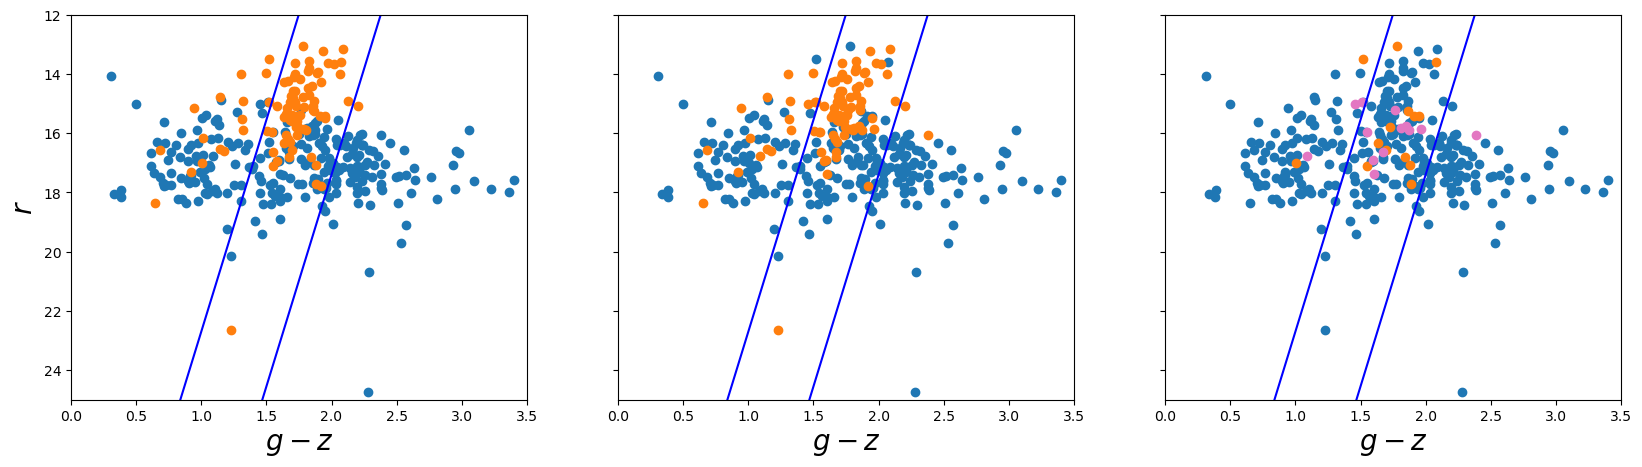

In [49]:
fig1, axs1 = plt.subplots(1, 3, figsize = (20, 5), sharey=True)

gz_slope = -14.3
gz_intercept1 = 37
gz_intercept2 = 46 # is this one intense enough?
xx = np.linspace(0, 4)

axs1[0].plot(xx, xx*gz_slope + gz_intercept1, 'b-', label = f'y = {str(gz_slope)}x + {str(gz_intercept1)}')
axs1[0].plot(xx, xx*gz_slope + gz_intercept2, 'b-', label = f'y = {str(gz_slope)}x + {str(gz_intercept2)}')
axs1[0].scatter(test_bgs_true['g_z'], test_bgs_true['R_mag'], c='C0')
axs1[0].scatter(test_members_true['g_z'], test_members_true['R_mag'], c='C11')
axs1[0].set_xlim([0, 3.5])
axs1[0].invert_yaxis()
axs1[0].set_xlabel('$g-z$', fontsize = 20)

axs1[1].plot(xx, xx*gz_slope + gz_intercept1, 'b-', label = f'y = {str(gz_slope)}x + {str(gz_intercept1)}')
axs1[1].plot(xx, xx*gz_slope + gz_intercept2, 'b-', label = f'y = {str(gz_slope)}x + {str(gz_intercept2)}')
axs1[1].scatter(test_bgs_pred['g_z'], test_bgs_pred['R_mag'], c='C0')
axs1[1].scatter(test_members_pred['g_z'], test_members_pred['R_mag'], c='C11')
axs1[1].set_xlim([0, 3.5])
axs1[1].invert_yaxis()
axs1[1].set_xlabel('$g-z$', fontsize = 20)

axs1[2].plot(xx, xx*gz_slope + gz_intercept1, 'b-', label = f'y = {str(gz_slope)}x + {str(gz_intercept1)}')
axs1[2].plot(xx, xx*gz_slope + gz_intercept2, 'b-', label = f'y = {str(gz_slope)}x + {str(gz_intercept2)}')
axs1[2].scatter(test_zero_diffs['g_z'], test_zero_diffs['R_mag'], c='C0')
axs1[2].scatter(test_pos_diffs['g_z'], test_pos_diffs['R_mag'], c='C11')
axs1[2].scatter(test_neg_diffs['g_z'], test_neg_diffs['R_mag'], c='C6')
axs1[2].set_xlim([0, 3.5])
axs1[2].invert_yaxis()
axs1[2].set_xlabel('$g-z$', fontsize = 20)

axs1[0].set_ylabel('$r$', fontsize = 20)
axs1[0].set_ylim([25, 12])

plt.savefig('../Images/WriteUpFigs/indepTest-classify.png')